In [108]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import evaluation
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler

In [110]:
from pyspark.sql import SparkSession

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_6f87b1d25f3b4023bbd4eb9a54f4fa7c(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '5bf68650a13f47d9a10fb4d0f20e1c05')
    hconf.set(prefix + '.username', 'f2e695ab5f6e43d3a7e569148c5cd27a')
    hconf.set(prefix + '.password', 'Xi(3#zNmtL51Td[T')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_6f87b1d25f3b4023bbd4eb9a54f4fa7c(name)

spark = SparkSession.builder.getOrCreate()

df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://bikeshare.' + name + '/all_keywords.csv')
df_data_1.take(5)
df_data_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://bikeshare.' + name + '/all_keywords.csv')
df_data_2.take(5)


[Row(Trip Duration=u'680', Start Time=u'2017-01-01 00:00:21', Stop Time=u'2017-01-01 00:11:41', Start Station ID=u'3226', Start Station Name=u'W 82 St & Central Park West', Start Station Latitude=u'40.78275', Start Station Longitude=u'-73.97137', End Station ID=u'3165', End Station Name=u'Central Park West & W 72 St', End Station Latitude=u'40.77579376683666', End Station Longitude=u'-73.9762057363987', Bike ID=u'25542', User Type=u'Subscriber', Birth Year=u'1965', Gender=u'2'),
 Row(Trip Duration=u'1282', Start Time=u'2017-01-01 00:00:45', Stop Time=u'2017-01-01 00:22:08', Start Station ID=u'3263', Start Station Name=u'Cooper Square & E 7 St', Start Station Latitude=u'40.72923649910006', Start Station Longitude=u'-73.99086803197861', End Station ID=u'498', End Station Name=u'Broadway & W 32 St', End Station Latitude=u'40.74854862', End Station Longitude=u'-73.98808416', Bike ID=u'21136', User Type=u'Subscriber', Birth Year=u'1987', Gender=u'2'),
 Row(Trip Duration=u'648', Start Time=u

In [112]:
bikeshare = spark.read.csv('swift://bikeshare.' + name + '/all_keywords.csv', header="true", inferSchema="true",mode="DROPMALFORMED")

In [113]:
bikeshare.show(5)

+-------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+----------+------+
|Trip Duration|         Start Time|          Stop Time|Start Station ID|  Start Station Name|Start Station Latitude|Start Station Longitude|End Station ID|    End Station Name|End Station Latitude|End Station Longitude|Bike ID| User Type|Birth Year|Gender|
+-------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+----------+------+
|          680|2017-01-01 00:00:21|2017-01-01 00:11:41|            3226|W 82 St & Central...|              40.78275|              -73.97137|          3165|Central Park West...|   40.77579376683666|    -73.9762057363987|  25542|Su

In [114]:
assembler = VectorAssembler(inputCols = ["Start Station Latitude","Start Station Longitude"], outputCol="features")
train = assembler.transform(bikeshare)

knum = 5
kmeans = KMeans(featuresCol=assembler.getOutputCol(), predictionCol="cluster", k=knum, seed=456789)
model = kmeans.fit(train)
print "Model Created!"

Model Created!


In [115]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.72839126 -73.97171605]
[ 0.  0.]
[ 40.7303193  -73.99846003]
[ 40.76479815 -73.97713413]
[ 40.68620228 -73.97968312]


In [116]:
prediction = model.transform(train)
prediction.groupBy("cluster").count().orderBy("cluster").show()

+-------+------+
|cluster| count|
+-------+------+
|      0|351316|
|      1|     2|
|      2|907010|
|      3|754900|
|      4|232760|
+-------+------+



In [117]:
prediction.select("Start Station ID", "cluster").show(50)

+----------------+-------+
|Start Station ID|cluster|
+----------------+-------+
|            3226|      3|
|            3263|      2|
|            3143|      3|
|            3143|      3|
|            3143|      3|
|            3163|      3|
|             499|      3|
|             362|      3|
|             430|      4|
|            3165|      3|
|             528|      0|
|             474|      2|
|             524|      3|
|             297|      2|
|             515|      3|
|            3172|      3|
|             515|      3|
|             423|      3|
|             267|      3|
|             369|      2|
|            3139|      3|
|             279|      2|
|             301|      0|
|             128|      2|
|             449|      3|
|             449|      3|
|             449|      3|
|             153|      3|
|             368|      2|
|             513|      3|
|             449|      3|
|             449|      3|
|             523|      3|
|            3255|      2|
|

In [118]:
customerCluster = {}
for i in range(0,knum):
    tmp = prediction.select("Trip Duration", "Start Time", "Stop Time", "Start Station ID", "Start Station Name", \
                                        "Start Station Latitude", "Start Station Longitude", "End Station ID", "End Station Name", "End Station Latitude","End Station Longitude","Bike ID","User Type","Birth Year","Gender")\
                                    .where("cluster =" +  str(i))
    customerCluster[str(i)]= tmp
    print "Cluster"+str(i)
    customerCluster[str(i)].show(10)

Cluster0
+-------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+----------+------+
|Trip Duration|         Start Time|          Stop Time|Start Station ID|  Start Station Name|Start Station Latitude|Start Station Longitude|End Station ID|    End Station Name|End Station Latitude|End Station Longitude|Bike ID| User Type|Birth Year|Gender|
+-------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+----------+------+
|         1081|2017-01-01 00:07:49|2017-01-01 00:25:50|             528|     2 Ave & E 31 St|           40.74290902|           -73.97706058|           526|     E 33 St & 5 Ave|         40.74765947|         -73.98490707| 

In [119]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.tools.plotting import scatter_matrix

save1 = prediction.select("Start Station ID", "cluster","Start Station Latitude", "Start Station Longitude")
ts = save1.toPandas()
ts.head(5)

,Start Station ID,cluster,Start Station Latitude,Start Station Longitude
0,3226,3,40.782750,-73.971370
1,3263,2,40.729236,-73.990868
2,3143,3,40.776829,-73.963888
3,3143,3,40.776829,-73.963888
4,3143,3,40.776829,-73.963888


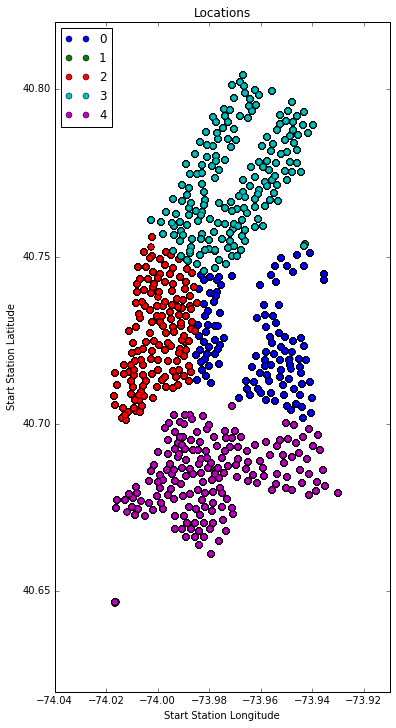

In [122]:
df = ts
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

def scatter(group):
    plt.plot(group['Start Station Longitude'],
             group['Start Station Latitude'],
             'o', label=group.name)

df.groupby('cluster').apply(scatter)



ax.set(xlabel='Start Station Longitude',
       ylabel='Start Station Latitude',
       title='Locations',
       xlim=[-74.04,-73.91],
       ylim=[40.62,40.82])

ax.legend(loc=2)

In [121]:
save2 = prediction.groupBy("cluster").count().orderBy("cluster")
ts2 = save2.toPandas()
ts2.head()

,cluster,count
0,0,351316
1,1,2
2,2,907010
3,3,754900
4,4,232760
